# Functional Encryption - Classification and information leakage


### Purpose

We do the same task as part 15 except the collateral CNN attacking is bigger than the one used for the resistance

As a remainder, what we want to do is to optimize the following problem:
$ \min_Q [ \min_C l_C(Q, C) - \alpha \min_F l_F(Q, F) ] $


Hence, the game is in 3 epoch time (and `F` is a CNN):
 - The normal phase where both tasks learn and strenghten before the joint optimisation:
  - `Optimize: Q + C`
  - `Optimize: Freezed(Q) + F`
 - The phase with the joint optimisation, where C and F are updated depending on the Q variations and Q is optimised to reduce the loss `C - alpha * F`:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + F`
  - `Optimize : Q + [Freezed(C) - alpha * Freezed(F)]`
 - The recovery part, where both tasks recover from the perturbation, `Q` won't change now:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + F`


# 1. Joint optimisation


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [3]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 3
        self.sabotage_epochs = 3
        self.recovering_epochs = 3
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [4]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- Junction
        self.jct = nn.Linear(8, 784)
        
        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)
        
        # --- Junction
        self.adv_jct = nn.Linear(8, 784)
        
        # --- Advanced CNN for familiers
        self.adv_conv1 = nn.Conv2d(1, 30, 4, 1)
        self.adv_conv2 = nn.Conv2d(30, 100, 4)
        self.adv_fc1 = nn.Linear(100 * 4 * 4, 1000)
        self.adv_fc2 = nn.Linear(1000, 100)
        self.adv_fc3 = nn.Linear(100, N_FONTS)
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def conv_adv_font(self, x):
        # --- Junction
        x = self.adv_jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.adv_conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.adv_conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*100)
        x = F.relu(self.adv_fc1(x))
        x = F.relu(self.adv_fc2(x))
        x = self.adv_fc3(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_adv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        elif net == 'adv_font':
            layers = [self.adv_jct, self.adv_fc1, self.adv_fc2, self.adv_fc3, self.adv_conv1, self.adv_conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [5]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, recover):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        if not recover: # building resistance
            # Optimize C and F parts of the model with 2 strategies
            if initial_phase:  # Normal optimisation of C
                # Phase 1: Optimise Q + C
                optimizer.zero_grad()
                output = model.forward_char(data)
                loss_char = F.nll_loss(output, target_char)
                loss_char.backward()
                optimizer.step()
            else: # Freezed(Q) optimisation
                # Phase 1: Optimise Freezed(Q) + C
                model.freeze('quad')
                optimizer.zero_grad()
                output_char = model.forward_char(data)
                loss_char = F.nll_loss(output_char, target_char)
                loss_char.backward()
                optimizer.step()
                model.unfreeze()
            # Phase 2: Optimise Freezed(Q) + F
            model.freeze('quad')
            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()

            if perturbate:
                # Optimize Q
                model.freeze('font')
                model.freeze('char')
                optimizer.zero_grad()
                output_char = model.forward_char(data)
                loss_char = F.nll_loss(output_char, target_char)

                output_font = model.forward_font(data)
                loss_font = F.nll_loss(output_font, target_font)

                loss = loss_char - alpha * loss_font
                loss.backward()
                optimizer.step()
                model.unfreeze()
        else: # recover phase: we change the collateral adversary
            loss_char = 0.
            model.freeze('quad')
            optimizer.zero_grad()
            output_font = model.forward_adv_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()

        if batch_idx % args.log_interval == 0:
            loss_char = loss_char.item() if loss_char != 0 else loss_char
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char, loss_font.item()))

In [6]:
def test(args, model, test_loader, recover):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            output = model.forward_char(data)
            pred = output.argmax(1, keepdim=True)
            correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            if not recover:
                output = model.forward_font(data)
            else:
                output = model.forward_adv_font(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

Now we can handle the main function. The only thing that really changes is that we now want to have both labels associated to a input item.

In [7]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset

Last the main function !

In [8]:
def main(alpha=0):
    """
    Perform a learning phase
    """
    torch.manual_seed(1)
    args = Parser()

    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
   
    model = QuadConvNet()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.recovering_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        recover = epoch > args.epochs + args.sabotage_epochs
        if recover:
            print("(recover: new adversary)")
        
        assert initial_phase or perturbate or recover
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, recover)
        test_perf_char, test_perf_font = test(args, model, test_loader, recover)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font, model

In [9]:
results = {}
alphas = [1.5] #0.05, 0.1, 0.2, 0.5, 1, 1.5, 2
for alpha in alphas:
    test_perfs_char_perturbate, test_perfs_font_perturbate, model_perturbate = main(alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.280601 Loss Font: 1.622234
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.220582 Loss Font: 1.610128
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.162734 Loss Font: 1.611208
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.027703 Loss Font: 1.605242
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.826648 Loss Font: 1.598936
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.521577 Loss Font: 1.581170
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.311489 Loss Font: 1.568406
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 2.052406 Loss Font: 1.591820
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.910080 Loss Font: 1.477296
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.573602 Loss Font: 1.483758

Test set: Accuracy Char : 5102/10000 (51.02%)
          Accuracy Font : 3202/10000 (32.02%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.277711 Loss Font: 1.489478
Train Epoch

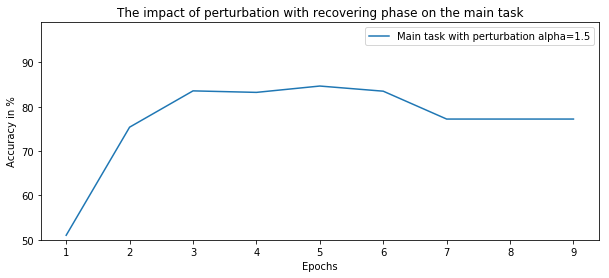

In [10]:
main_results = {k:v for k, v in results.items() if 'Main' in k}
show_results(main_results, "The impact of perturbation with recovering phase on the main task", ymin=50, ymax=99)

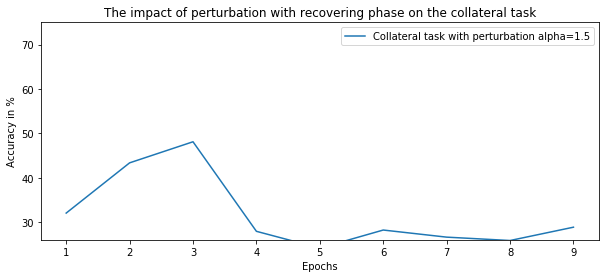

In [11]:
collateral_results = {k:v for k, v in results.items() if 'Collateral' in k}
show_results(collateral_results, "The impact of perturbation with recovering phase on the collateral task", ymin=26, ymax=75)

Compared to Part 15, we observe that the large model does not behave much better at all, which suggest we have scaled resistance at a sufficient point.

## Conclusion

So the resistance in the CNN family is also pretty good as well!